<a href="https://colab.research.google.com/github/data-to-insights/COLLECTIVE2_TRADING/blob/master/02_Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimFin Tutorial 02 - Resampling

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"I believe this is going to be a very difficult *croning* job. *Cloning* you idiot, not *croning!*" &ndash; [The Sleeper](https://www.youtube.com/watch?v=27PGmG0k2Kk)

## Introduction

Resampling is a very common operation on financial data. The fundamental data in Balance Sheets, Income Statements and Cash-Flow Statements is only provided at quarterly or annual intervals, corresponding to the financial reports of the companies. If we want to use this data to calculate daily valuation ratios such as P/E or P/Sales then we first need to upsample the fundamental data.

Broadly speaking, Pandas provides three methods for resampling data. They can all up- and downsample the data, but their features are slightly different:

- **AsFreq** is the simplest resampling method, which only allows filling in the missing values backwards or forwards.

- **Resample** is a more flexible resampling method, which allows more advanced interpolation when filling in missing values for upsampling, and also allows more advanced summarization methods for downsampling.

- **Reindex** conforms a DataFrame to the index of another DataFrame, which will be explained in more detail below.

The syntax for these resampling methods is complex and confusing, so after explaining how to use the Pandas methods on SimFin data, we also show some helper-functions from the simfin package, that you may want to use instead of Pandas' native methods.

It is assumed you are already familiar with Tutorial 01 on the basics of SimFin before you read this tutorial.

In [ ]:
# !pip install simfin

     |████████████████████████████████| 61kB 2.1MB/s 


## Imports

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.7.0'

## Config

In [ ]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [ ]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [ ]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Load Datasets

We will use the datasets for annual Income Statements and daily Share-Prices in these examples. In reality you would typically want to use the TTM-data instead, to get 4 yearly data-points instead of just 1 yearly data-point when using annual reports.

In [ ]:
%%time
market = 'us'
df_income = sf.load_income(variant='annual', market=market)
df_prices = sf.load_shareprices(variant='daily', market=market)
df_prices_latest = sf.load_shareprices(variant='latest', market=market)

Dataset "us-income-annual" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-latest" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
CPU times: user 22.6 s, sys: 3.4 s, total: 26 s
Wall time: 34.8 s


We will only use a sub-set of the datasets for tickers AAPL, AMZN and MSFT.

In [ ]:
tickers = ['AAPL', 'AMZN', 'MSFT']
df_income = df_income.loc[tickers, [REVENUE, NET_INCOME]].copy()
df_prices = df_prices.loc[tickers, [CLOSE, ADJ_CLOSE]].copy()
df_prices_latest = df_prices_latest.loc[tickers, [CLOSE, ADJ_CLOSE]].copy()

In [ ]:
df_income

Revenue   Net Income
Ticker Report Date                           
AAPL   2008-09-30   3.749100e+10   6119000000
       2009-09-30   4.290500e+10   8235000000
       2010-09-30   6.522500e+10  14013000000
       2011-09-30   1.082490e+11  25922000000
       2012-09-30   1.565080e+11  41733000000
       2013-09-30   1.709100e+11  37037000000
       2014-09-30   1.827950e+11  39510000000
       2015-09-30   2.337150e+11  53394000000
       2016-09-30   2.156390e+11  45687000000
       2017-09-30   2.292340e+11  48351000000
       2018-09-30   2.655950e+11  59531000000
AMZN   2008-12-31   1.916600e+10    645000000
       2009-12-31   2.450900e+10    902000000
       2010-12-31   3.420400e+10   1152000000
       2011-12-31   4.807700e+10    631000000
       2012-12-31   6.109300e+10    -39000000
       2013-12-31   7.445200e+10    274000000
       2014-12-31   8.898800e+10   -241000000
       2015-12-31   1.070060e+11    596000000
       2016-12-31   1.359870e+11   2371000000
       2017-12-31   1.778660e+11   3033000000
       2018-12-31   2.328870e+11  10073000000
MSFT   2009-06-30   5.843700e+10  14569000000
       2010-06-30   6.248400e+10  18760000000
       2011-06-30   6.994300e+10  23150000000
       2012-06-30   7.372300e+10  16978000000
       2013-06-30   7.784900e+10  21863000000
       2014-06-30   8.683300e+10  22074000000
       2015-06-30   9.358000e+10  12193000000
       2016-06-30   9.115400e+10  20539000000
       2017-06-30   9.657100e+10  25489000000
       2018-06-30   1.103600e+11  16571000000
       2019-06-30   1.258430e+11  39240000000

In [ ]:
df_prices.head()

Close  Adj. Close
Ticker Date                           
AAPL   2007-01-03  11.9714       10.36
       2007-01-04  12.2371       10.59
       2007-01-05  12.1500       10.52
       2007-01-08  12.2100       10.57
       2007-01-09  13.2243       11.45

In [ ]:
df_prices_latest.head()

,,Close,Adj. Close
Ticker,Date,,
AAPL,2020-06-29,361.78,361.78
AMZN,2020-06-29,2680.38,2680.38
MSFT,2020-06-29,198.44,198.44


## AsFreq

The simplest form of resampling in Pandas is called `asfreq` (presumably short for 'as frequency'). It can fill in the missing-values using either 'ffill' (forward fill) or 'bfill' (backward fill).

For example, we can upsample the annual Income Statements to daily data for the ticker MSFT, by forward-filling the missing values from the last-known values:

In [ ]:
df_income.loc['MSFT'].asfreq(freq='D', method='ffill')

,Revenue,Net Income
Report Date,,
2009-06-30,5.843700e+10,14569000000
2009-07-01,5.843700e+10,14569000000
2009-07-02,5.843700e+10,14569000000
2009-07-03,5.843700e+10,14569000000
2009-07-04,5.843700e+10,14569000000
...,...,...
2019-06-26,1.103600e+11,16571000000
2019-06-27,1.103600e+11,16571000000
2019-06-28,1.103600e+11,16571000000


If we plot the upsampled data, it will show as "staircase" patterns because the forward-filling simply copies the last-known values:

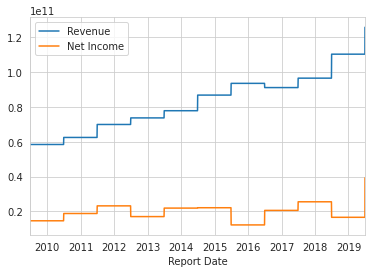

In [ ]:
df_income.loc['MSFT'].asfreq(freq='D', method='ffill').plot()

### AsFreq on MultiIndex

If we try to do `asfreq` resampling on a DataFrame with multiple tickers, then it raises an exception because `asfreq` does not support DataFrames with MultiIndex:

In [ ]:
try:
    df_income.asfreq('D', method='ffill')
except Exception as e:
    print(e)

Cannot convert input [('AAPL', Timestamp('2008-09-30 00:00:00'))] of type <class 'tuple'> to Timestamp


We need to split the DataFrame into sub-groups for each of the tickers, and perform the `asfreq` operation on each of those sub-groups, and then glue the results back together into a single DataFrame. Remember from Tutorial 01 that the `groupby` operation does exactly this.

There are many ways of using `groupby` but the simplest I have been able to come up with so far, is the following. You can make the notation a little more compact (but probably also harder to read and understand), by using a lambda-function and chained calls instead.

In [ ]:
def _asfreq(df_grp):
    # Remove TICKER from the MultiIndex.
    df_grp = df_grp.reset_index(TICKER, drop=True)
    
    # Perform the operation on this group.
    df_result = df_grp.asfreq(freq='D', method='ffill')

    return df_result

# Split the DataFrame into sub-groups and apply the _asfreq()
# function on each of those sub-groups, and then glue the
# results back together into a single DataFrame.
df_income.groupby(TICKER).apply(_asfreq)

Revenue   Net Income
Ticker Report Date                           
AAPL   2007-09-30   2.457800e+10   3495000000
       2007-10-01   2.457800e+10   3495000000
       2007-10-02   2.457800e+10   3495000000
       2007-10-03   2.457800e+10   3495000000
       2007-10-04   2.457800e+10   3495000000
...                          ...          ...
MSFT   2019-06-26   1.103600e+11  16571000000
       2019-06-27   1.103600e+11  16571000000
       2019-06-28   1.103600e+11  16571000000
       2019-06-29   1.103600e+11  16571000000
       2019-06-30   1.258430e+11  39240000000

[12421 rows x 2 columns]

### AsFreq Helper-Function

It is hard to remember the above syntax for doing `asfreq` on a DataFrame with a MultiIndex, so the simfin package provides a helper-function that can take both Pandas DataFrames and Series, either having a single DatatimeIndex, or a MultiIndex with two indices, one of which is a DatetimeIndex and the other is e.g. the Ticker or SimFin_Id.

For example, this is how you would do `asfreq` on a DataFrame for a single stock:

In [ ]:
sf.asfreq(df=df_income.loc['MSFT'], freq='D', method='ffill')

,Revenue,Net Income
Report Date,,
2009-06-30,5.843700e+10,14569000000
2009-07-01,5.843700e+10,14569000000
2009-07-02,5.843700e+10,14569000000
2009-07-03,5.843700e+10,14569000000
2009-07-04,5.843700e+10,14569000000
...,...,...
2019-06-26,1.103600e+11,16571000000
2019-06-27,1.103600e+11,16571000000
2019-06-28,1.103600e+11,16571000000


This is how you would do `asfreq` on a DataFrame with multiple stocks:

In [ ]:
sf.asfreq(df=df_income, freq='D', method='ffill')

Revenue   Net Income
Ticker Report Date                           
AAPL   2008-09-30   3.749100e+10   6119000000
       2008-10-01   3.749100e+10   6119000000
       2008-10-02   3.749100e+10   6119000000
       2008-10-03   3.749100e+10   6119000000
       2008-10-04   3.749100e+10   6119000000
...                          ...          ...
MSFT   2019-06-26   1.103600e+11  16571000000
       2019-06-27   1.103600e+11  16571000000
       2019-06-28   1.103600e+11  16571000000
       2019-06-29   1.103600e+11  16571000000
       2019-06-30   1.258430e+11  39240000000

[10959 rows x 2 columns]

For convenience, a function is provided for `asfreq` with daily frequency:

In [ ]:
sf.asfreq_daily(df=df_income, method='ffill')

Revenue   Net Income
Ticker Report Date                           
AAPL   2008-09-30   3.749100e+10   6119000000
       2008-10-01   3.749100e+10   6119000000
       2008-10-02   3.749100e+10   6119000000
       2008-10-03   3.749100e+10   6119000000
       2008-10-04   3.749100e+10   6119000000
...                          ...          ...
MSFT   2019-06-26   1.103600e+11  16571000000
       2019-06-27   1.103600e+11  16571000000
       2019-06-28   1.103600e+11  16571000000
       2019-06-29   1.103600e+11  16571000000
       2019-06-30   1.258430e+11  39240000000

[10959 rows x 2 columns]

We can easily plot the resampled data using the Seaborn plotting package. Note that the index is first reset on the DataFrame, because that is how Seaborn wants the DataFrame.

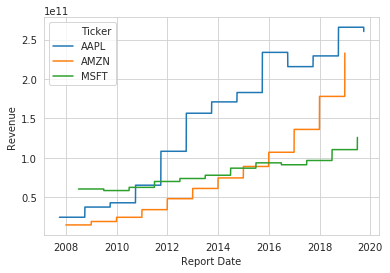

In [ ]:
# Upsample annual Income Statements for several tickers.
df_daily = sf.asfreq_daily(df_income, method='ffill')

# Plot.
sns.lineplot(x=REPORT_DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

## Resample

If a simple forward/backward-fill is not sufficient for you, or if you want to downsample data e.g. by taking the average of many data-points, then Pandas provides the `resample` function.

For example, we can use the `resample` function to upsample a DataFrame for a single company which only has a DatetimeIndex. If we use forward-fill again, then it gives the same "staircase" plot as we saw for `asfreq` above:

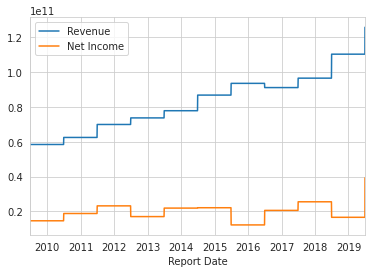

In [ ]:
df_income.loc['MSFT'].resample('D').ffill().plot()

The `resample` function can also use more advanced methods for filling in the empty data-points. For example, linear interpolation fills in the empty data-points with straight lines between the known points.

This is a form of cheating called "look-ahead bias" because we are using future data when filling in the empty data-points. This should be avoided when developing and testing trading-strategies, but it is still useful in some forms of data-analysis.

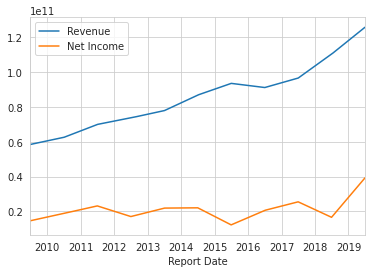

In [ ]:
df_income.loc['MSFT'].resample('D').interpolate(method='linear').plot()

The `resample` function can also be used to downsample data. For example, we can downsample by taking the average of every month's share-price data:

In [ ]:
df_prices.loc['MSFT'].resample('M').mean().head()

,Close,Adj. Close
Date,,
2007-01-31,30.530500,22.623500
2007-02-28,29.190000,21.672632
2007-03-31,27.694995,20.590909
2007-04-30,28.725000,21.359000
2007-05-31,30.743295,22.900000


We can also plot the downsampled monthly share-price data:

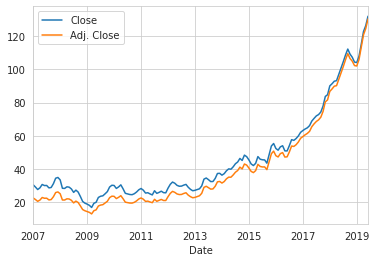

In [ ]:
df_prices.loc['MSFT'].resample('M').mean().plot()

### Resample on MultiIndex

If we try to resample a DataFrame with multiple tickers, then it raises an exception because Pandas' `resample` function does not support DataFrames with MultiIndex:

In [ ]:
try:
    df_income.resample('D').ffill()
except Exception as e:
    print(e)

Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'


Pandas' `resample` function provides an argument `level=` which can be used to select a specific column in a MultiIndex, but its semantics are unclear from the documentation, and it does not work when upsampling anyway.

In [ ]:
try:
    df_income.resample('D', level=REPORT_DATE).ffill()
except Exception as e:
    print(e)

Upsampling from level= or on= selection is not supported, use .set_index(...) to explicitly set index to datetime-like


As we did for the `asfreq` function above, we need to split the DataFrame into sub-groups for each of the Tickers, and perform the `resample` operation on each of those sub-groups, and then glue the results back together into a single DataFrame.

The following could be made more compact (but maybe also harder to understand) by instead using a lambda-function with chained calls:

In [ ]:
def _resample(df_grp):
    # Remove TICKER from the MultiIndex.
    df_grp = df_grp.reset_index(TICKER, drop=True)
    
    # Resample and forward-fill NA values.
    df_result = df_grp.resample('D').ffill()

    return df_result

# Split the DataFrame into sub-groups and apply the _resample()
# function on each of those sub-groups, and then glue the
# results back together into a single DataFrame.
df_income.groupby(TICKER).apply(_resample)

Revenue   Net Income
Ticker Report Date                           
AAPL   2008-09-30   3.749100e+10   6119000000
       2008-10-01   3.749100e+10   6119000000
       2008-10-02   3.749100e+10   6119000000
       2008-10-03   3.749100e+10   6119000000
       2008-10-04   3.749100e+10   6119000000
...                          ...          ...
MSFT   2019-06-26   1.103600e+11  16571000000
       2019-06-27   1.103600e+11  16571000000
       2019-06-28   1.103600e+11  16571000000
       2019-06-29   1.103600e+11  16571000000
       2019-06-30   1.258430e+11  39240000000

[10959 rows x 2 columns]

### Resample Helper-Function

Because Pandas' syntax is complicated for resampling a DataFrame with a MultiIndex, the simfin package also provides a helper-function for `resample`, that can take both Pandas DataFrames and Series, either having a single DatatimeIndex, or a MultiIndex with two indices, one of which is a DatetimeIndex and the other is e.g. the Ticker or SimFin_Id.

Note that the helper-function uses the keyword argument `rule` instead of `freq` that was used in the `asfreq()` functions above. This inconsistency is simply inherited from Pandas, which uses the keyword `rule` in the `resample` function and the keyword `freq` in the `asfreq` function.

For example, this is how you would upsample a DataFrame with annual data for a single stock into daily data-points using the forward-fill method:

In [ ]:
sf.resample(df=df_income.loc['MSFT'], rule='D', method='ffill').head()

,Revenue,Net Income
Report Date,,
2009-06-30,5.843700e+10,14569000000
2009-07-01,5.843700e+10,14569000000
2009-07-02,5.843700e+10,14569000000
2009-07-03,5.843700e+10,14569000000
2009-07-04,5.843700e+10,14569000000


We can also plot the upsampled data. Because we are using the forward-fill method, the last-known values are merely copied forward to the unknown data-points, which shows up as a "staircase" pattern in the plot:

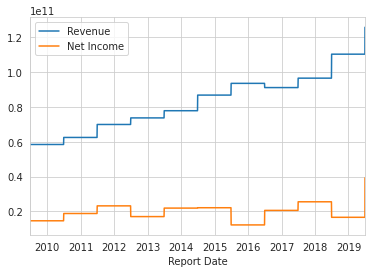

In [ ]:
sf.resample(df=df_income.loc['MSFT'], rule='D', method='ffill').plot()

We can also interpolate between known values when doing the upsampling by setting the argument `method='linear'` instead of `'ffill'`. As noted above, this is a form of cheating, because we are using data before it was actually known. This should not be done in trading strategies, although it is still useful in some data-analysis.

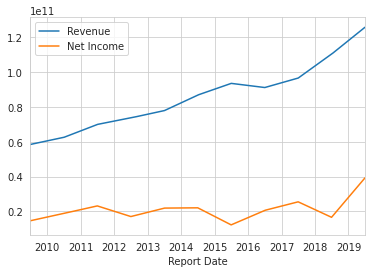

In [ ]:
sf.resample(df=df_income.loc['MSFT'], rule='D', method='linear').plot()

Because resampling to daily data is a very common operation, a convenience function is provided for doing that, so we don't have to write the argument `rule='D'`:

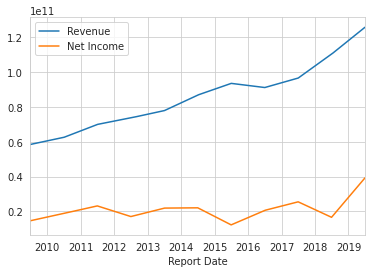

In [ ]:
sf.resample_daily(df=df_income.loc['MSFT'], method='linear').plot()

We can also use the helper-function for resampling a DataFrame with multiple tickers:

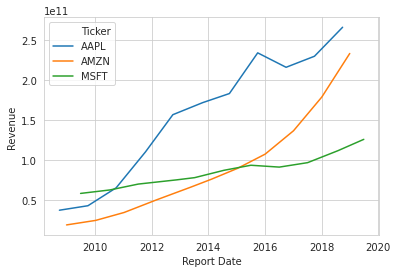

In [ ]:
# Resample annual Income Statements for multiple tickers.
df_daily = sf.resample(df=df_income, rule='D', method='linear')

# Plot.
sns.lineplot(x=REPORT_DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

We can also provide a custom method for the resampling function. For example, this method fills in the unknown values with quadratic interpolation between the known values:

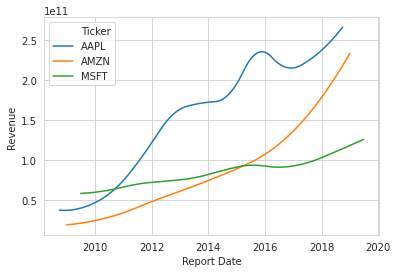

In [ ]:
# Custom method for the resampling.
method = lambda x: x.interpolate(method='quadratic')

# Do the resampling using the custom method.
df_daily = sf.resample(df=df_income, rule='D', method=method)

# Plot.
sns.lineplot(x=REPORT_DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

We can also use the helper-function to downsample data. For example, we can downsample the share-prices from daily to 3-month data using averaging. We resample all columns in the DataFrame but only plot the ADJ_CLOSE which is the close-price adjusted for both stock-splits and dividends (aka. Total Return). We also normalize the time-series so they all start at 1.0.

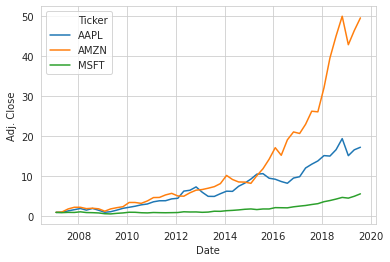

In [ ]:
# Downsample to 3-month data-points using averaging.
df_monthly = sf.resample(df=df_prices, rule='3M', method='mean')

# Drop rows with any empty data.
df_monthly = df_monthly.dropna(how='any')

# Normalize so the time-series for each stock begins at 1.0
_normalize = lambda df_grp: df_grp.div(df_grp.iloc[0])
df_norm = df_monthly.groupby(TICKER).apply(_normalize)

# Plot.
sns.lineplot(x=DATE, y=ADJ_CLOSE, hue=TICKER,
             data=df_norm.reset_index())

## Reindex

Both of the above methods `resample` and `asfreq` only change the data *between* the start- and end-dates of the original data. For example, the annual Income Statements for ticker MSFT range between 2008-06-30 and 2019-06-30, so if we upsample to daily data, we still only get data-points between these two dates. At the time of this writing, we are already in 2019-11-xx (November), so there's more than 4 months of data-points we do not get when upsampling the Income Statements using `resample` and `asfreq`.

We can instead use the `reindex` function to resample a DataFrame onto another index. This allows us to get new data-points beyond the original date-range of the data. For example, we can use this to calculate valuation ratios such as P/E or P/Sales for all dates where we have share-prices, using the last-known values from the Income Statements.

However, there are several difficulties when using `reindex` for resampling, which we will demonstrate below.

First let us show the annual Income Statements for ticker MSFT that we want to upsample to daily data-points until the most recent share-price date 2019-11-05. Note that we have all annual reports between 2008-06-30 and 2019-06-30, none of them are missing.

In [ ]:
df_income.loc['MSFT']

,Revenue,Net Income
Report Date,,
2009-06-30,5.843700e+10,14569000000
2010-06-30,6.248400e+10,18760000000
2011-06-30,6.994300e+10,23150000000
2012-06-30,7.372300e+10,16978000000
2013-06-30,7.784900e+10,21863000000
2014-06-30,8.683300e+10,22074000000
2015-06-30,9.358000e+10,12193000000
2016-06-30,9.115400e+10,20539000000
2017-06-30,9.657100e+10,25489000000


This is the index from the daily share-prices for ticker MSFT, which contains data-points for all trading-days (excluding weekends and holidays) between 2007-01-03 and 2019-11-05.

In [ ]:
new_index = df_prices.loc['MSFT'].index
new_index

DatetimeIndex(['2007-01-03', '2007-01-04', '2007-01-05', '2007-01-08',
               '2007-01-09', '2007-01-10', '2007-01-11', '2007-01-12',
               '2007-01-16', '2007-01-17',
               ...
               '2019-06-17', '2019-06-18', '2019-06-19', '2019-06-20',
               '2019-06-21', '2019-06-24', '2019-06-25', '2019-06-26',
               '2019-06-27', '2019-06-28'],
              dtype='datetime64[ns]', name='Date', length=3144, freq=None)

We can then reindex the data for the annual Income Statements using the index of the daily share-prices. Because we haven't specified any filling-logic, the missing values are set to NaN for unknown.

In [ ]:
df_income2 = df_income.loc['MSFT'].reindex(index=new_index)
df_income2.head()

,Revenue,Net Income
Date,,
2007-01-03,NaN,NaN
2007-01-04,NaN,NaN
2007-01-05,NaN,NaN
2007-01-08,NaN,NaN
2007-01-09,NaN,NaN


Let us try and drop all rows with NaN from the reindexed DataFrame. This shows us the dates that actually contain valid data. We might expect this to equal the original data from `df_income.loc['MSFT']` above, but if you look closely you can see that several rows are missing for the dates: 2012-06-30, 2013-06-30, 2018-06-30, and 2019-06-30.

In [ ]:
df_income2.dropna()

,Revenue,Net Income
Date,,
2009-06-30,5.843700e+10,1.456900e+10
2010-06-30,6.248400e+10,1.876000e+10
2011-06-30,6.994300e+10,2.315000e+10
2014-06-30,8.683300e+10,2.207400e+10
2015-06-30,9.358000e+10,1.219300e+10
2016-06-30,9.115400e+10,2.053900e+10
2017-06-30,9.657100e+10,2.548900e+10


The missing dates are all in the weekends:

In [ ]:
# List of missing dates.
dates_missing = ['2012-06-30', '2013-06-30', '2018-06-30']

# Convert list of dates to Pandas index.
index_missing = pd.DatetimeIndex(dates_missing)

# Show the names of the days.
index_missing.day_name()

Index(['Saturday', 'Sunday', 'Saturday'], dtype='object')

The financial reports can easily have dates that fall in weekends, because their dates are usually just chosen as the last day in a given month, such as these:

In [ ]:
df_income.loc['MSFT'].loc[index_missing]

,Revenue,Net Income
2012-06-30,7.372300e+10,16978000000
2013-06-30,7.784900e+10,21863000000
2018-06-30,1.103600e+11,16571000000


But the share-prices only have dates for valid trading-days, not weekends and holidays:

In [ ]:
try:
    df_prices.loc['MSFT'].loc[index_missing]
except Exception as e:
    print(e)

"None of [DatetimeIndex(['2012-06-30', '2013-06-30', '2018-06-30'], dtype='datetime64[ns]', freq=None)] are in the [index]"


The solution is to reindex with the union of the indices from the annual Income Statements and the Share-Prices, which retains all the original data-points from the Income Statements, even though their dates may not be present in the Share-Prices data:

In [ ]:
# Index for the annual Income Statements.
index_src = df_income.loc['MSFT'].index

# Index for the valid trading-days of the Share-Prices.
index_target = df_prices.loc['MSFT'].index

# Union of the two indices.
new_union_index = index_src.union(index_target)

# Reindex the annual Income Statements using the union-index.
# The new data-points are not filled so they are NaN.
df_income2 = df_income.loc['MSFT'].reindex(index=new_union_index)

# Remove NaN to show that the original data is preserved.
df_income2.dropna()

,Revenue,Net Income
2009-06-30,5.843700e+10,1.456900e+10
2010-06-30,6.248400e+10,1.876000e+10
2011-06-30,6.994300e+10,2.315000e+10
2012-06-30,7.372300e+10,1.697800e+10
2013-06-30,7.784900e+10,2.186300e+10
2014-06-30,8.683300e+10,2.207400e+10
2015-06-30,9.358000e+10,1.219300e+10
2016-06-30,9.115400e+10,2.053900e+10
2017-06-30,9.657100e+10,2.548900e+10
2018-06-30,1.103600e+11,1.657100e+10


The reindexing function also allows us to specify the filling-logic for the missing data-points. For example, we can use 'ffill' (forward-fill) to use the last-known values. Note that the annual data-points have been upsampled beyond their original end-point on 2019-06-30, all the way up to the end of the share-price data on 2019-11-05, exactly as we wanted.

In [ ]:
df_income.loc['MSFT'].reindex(index=new_union_index,
                              method='ffill').dropna()

,Revenue,Net Income
2009-06-30,5.843700e+10,1.456900e+10
2009-07-01,5.843700e+10,1.456900e+10
2009-07-02,5.843700e+10,1.456900e+10
2009-07-06,5.843700e+10,1.456900e+10
2009-07-07,5.843700e+10,1.456900e+10
...,...,...
2019-06-25,1.103600e+11,1.657100e+10
2019-06-26,1.103600e+11,1.657100e+10
2019-06-27,1.103600e+11,1.657100e+10
2019-06-28,1.103600e+11,1.657100e+10


### Reindex on MultiIndex

Unlike the `asfreq` and `resample` functions, we can actually perform a `reindex` operation directly on a DataFrame with MultiIndex. Here we use the union of the indices from the DataFrames with Income Statements and Share-Prices:

In [ ]:
# Index for the annual Income Statements.
index_src = df_income.index

# Index for the valid trading-days of the share-prices.
index_target = df_prices.index

# Union of the two indices.
new_union_index = index_src.union(index_target)

# Set the names of the new index, this is not set by union().
new_union_index.names = index_target.names

# Reindex the annual Income Statements using the union-index.
# The new data-points are not filled so they are NaN.
df_income2 = df_income.reindex(index=new_union_index)

# Remove NaN to show that the original data is preserved.
df_income2.dropna()

Revenue    Net Income
Ticker Date                                  
AAPL   2008-09-30  3.749100e+10  6.119000e+09
       2009-09-30  4.290500e+10  8.235000e+09
       2010-09-30  6.522500e+10  1.401300e+10
       2011-09-30  1.082490e+11  2.592200e+10
       2012-09-30  1.565080e+11  4.173300e+10
       2013-09-30  1.709100e+11  3.703700e+10
       2014-09-30  1.827950e+11  3.951000e+10
       2015-09-30  2.337150e+11  5.339400e+10
       2016-09-30  2.156390e+11  4.568700e+10
       2017-09-30  2.292340e+11  4.835100e+10
       2018-09-30  2.655950e+11  5.953100e+10
AMZN   2008-12-31  1.916600e+10  6.450000e+08
       2009-12-31  2.450900e+10  9.020000e+08
       2010-12-31  3.420400e+10  1.152000e+09
       2011-12-31  4.807700e+10  6.310000e+08
       2012-12-31  6.109300e+10 -3.900000e+07
       2013-12-31  7.445200e+10  2.740000e+08
       2014-12-31  8.898800e+10 -2.410000e+08
       2015-12-31  1.070060e+11  5.960000e+08
       2016-12-31  1.359870e+11  2.371000e+09
       2017-12-31  1.778660e+11  3.033000e+09
       2018-12-31  2.328870e+11  1.007300e+10
MSFT   2009-06-30  5.843700e+10  1.456900e+10
       2010-06-30  6.248400e+10  1.876000e+10
       2011-06-30  6.994300e+10  2.315000e+10
       2012-06-30  7.372300e+10  1.697800e+10
       2013-06-30  7.784900e+10  2.186300e+10
       2014-06-30  8.683300e+10  2.207400e+10
       2015-06-30  9.358000e+10  1.219300e+10
       2016-06-30  9.115400e+10  2.053900e+10
       2017-06-30  9.657100e+10  2.548900e+10
       2018-06-30  1.103600e+11  1.657100e+10
       2019-06-30  1.258430e+11  3.924000e+10

But if we use forward-fill on the missing data-points and plot the result, something has gone very wrong, because the operation does not respect the grouping between tickers:

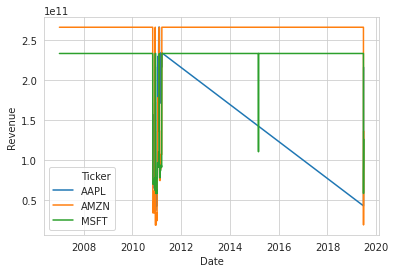

In [ ]:
# Reindex and forward-fill the annual Income Statements.
df_income2 = df_income.reindex(index=new_union_index,
                               method='ffill').dropna()

# Plot.
sns.lineplot(x=DATE, y=REVENUE, hue=TICKER,
             data=df_income2.reset_index())

Pandas' `reindex` function provides an argument `level` which supports DataFrames with a MultiIndex, but it is unclear from the brief documentation how it is supposed to work, and regardless of whether we use `level=TICKER` or `level=DATE` it raises the same exception:

In [ ]:
try:
    df_income2 = df_income.reindex(index=new_union_index,
                                   method='ffill', level=TICKER)
except Exception as e:
    print(e)

Fill method not supported if level passed


We have to manually use the `groupby` function on the reindexed DataFrame to group them by Tickers, and then fill the missing NaN values on each of those sub-groups:

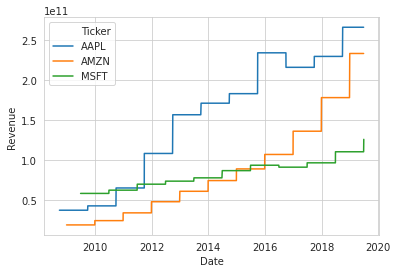

In [ ]:
# Reindex the annual Income Statements using the union-index.
# The new data-points are not filled so they are NaN.
df_income2 = df_income.reindex(index=new_union_index)

# Split the DataFrame into sub-groups and apply the ffill()
# function on each of those sub-groups, and then glue the
# results back together into a single DataFrame.
df_income3 = df_income2.groupby(TICKER).ffill()

# Remove empty rows.
df_income3.dropna(inplace=True)

# Plot.
sns.lineplot(x=DATE, y=REVENUE, hue=TICKER,
             data=df_income3.reset_index())

### Reindex Helper-Function

The above procedure for reindexing DataFrames using Pandas' native functions, is quite complicated and confusing. We have therefore provided a helper-function in the simfin package.

For example, we can reindex the annual Income Statements to match the index of the daily share-prices using forward-fill of missing values. Note how the resulting DataFrame has values for the last dates of the target DataFrame with share-prices, exactly as we want.

In [ ]:
df_daily = sf.reindex(df_src=df_income, df_target=df_prices,
                      group_index=TICKER, method='ffill').dropna()
df_daily

Revenue    Net Income
Ticker Date                                  
AAPL   2008-09-30  3.749100e+10  6.119000e+09
       2008-10-01  3.749100e+10  6.119000e+09
       2008-10-02  3.749100e+10  6.119000e+09
       2008-10-03  3.749100e+10  6.119000e+09
       2008-10-06  3.749100e+10  6.119000e+09
...                         ...           ...
MSFT   2019-06-24  1.103600e+11  1.657100e+10
       2019-06-25  1.103600e+11  1.657100e+10
       2019-06-26  1.103600e+11  1.657100e+10
       2019-06-27  1.103600e+11  1.657100e+10
       2019-06-28  1.103600e+11  1.657100e+10

[7863 rows x 2 columns]

We can also plot the reindexed DataFrame. Because we have used 'forward-fill' of the missing values, it looks like "staircase" patterns:

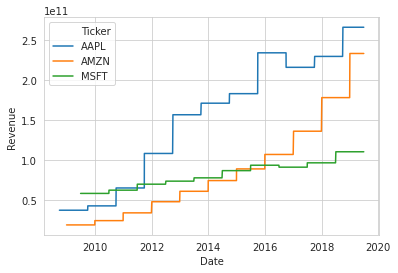

In [ ]:
sns.lineplot(x=DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

Here is an example of reindexing with linear interpolation. As noted further above, this is a form of cheating called "look-ahead bias" because we are interpolating between last-known and future values to fill in the missing values. This should be avoided when making trading-strategies, but may still be useful for some forms of analysis.

Note that the final segment after the last-known values just uses forward-fill.

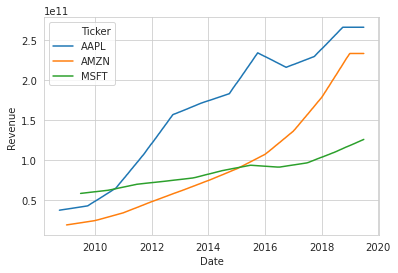

In [ ]:
# Reindex using linear interpolation.
df_daily = sf.reindex(df_src=df_income, df_target=df_prices,
                      group_index=TICKER, method='linear').dropna()

# Plot.
sns.lineplot(x=DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

We can also use a custom filling-method with the reindexing, e.g. quadratic interpolation.

Note that the final segment beyond the last-known values is missing when using this filling-method, unlike the linear interpolation above, which just used forward-fill for the final segment.

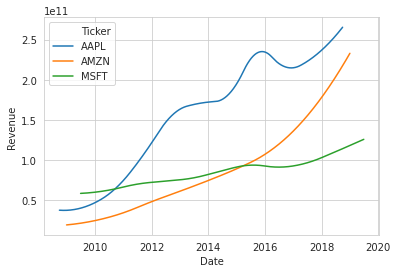

In [ ]:
# Custom method for the reindexing.
method = lambda x: x.interpolate(method='quadratic')

# Do the resampling using the custom method.
df_daily = sf.reindex(df_src=df_income, df_target=df_prices,
                      group_index=TICKER, method=method).dropna()

# Plot.
sns.lineplot(x=DATE, y=REVENUE, hue=TICKER,
             data=df_daily.reset_index())

### Reindex Helper-Function Arguments

By default the helper-function `sf.resample` has two arguments that are set to `union=True` and `only_target_index=True`. For upsampling quarterly or annual financial data so it can be used with daily share-prices, you would normally just leave them to their default `True` values. But sometimes you will need to change them, so they require some explanation.

The first argument `union` is a boolean that determines whether the reindexing should use the union of the indices from `df_src` and `df_target`, or only use the index for `df_target`. As discussed further above, reindexing drops the data-points from `df_src` when their dates do not exist in `df_target`, which can create "holes" in the data, and that is why it is sometimes necessary to reindex with the union of the two indices.

The second argument `only_target_index` is a boolean that determines whether to perform a second reindexing operation. This is only relevant if we have used the union of the indices from `df_src` and `df_target`, because the resulting DataFrame might have rows that do not exist in `df_target`. By setting `only_target_index=True` we ensure the resulting DataFrame matches the index of `df_target`.

Normally you would leave these arguments to their default values, so you can ignore them altogether. But sometimes you need different behaviour.

For example, let us say that we want to reindex the annual Income Statements, so that we have both the original data and a new data-point for the same date as the latest share-prices. This can be achieved by performing the reindexing with `union=True` so we use the indices of both the DataFrames, and `only_target_index=False` so we keep the rows from `df_income` whose dates were not in `df_prices_latest`.

In [ ]:
# Reindex the annual Income Statements with latest Share-Prices.
# Keep all the rows from the original DataFrame as well.
df_latest = sf.reindex(df_src=df_income,
                       df_target=df_prices_latest,
                       union=True, only_target_index=False,
                       method='ffill')

# Show the last 3 rows for each Ticker.
df_latest.groupby(TICKER).tail(3)

Revenue    Net Income
Ticker Date                                  
AAPL   2017-09-30  2.292340e+11  4.835100e+10
       2018-09-30  2.655950e+11  5.953100e+10
       2020-06-29  2.655950e+11  5.953100e+10
AMZN   2017-12-31  1.778660e+11  3.033000e+09
       2018-12-31  2.328870e+11  1.007300e+10
       2020-06-29  2.328870e+11  1.007300e+10
MSFT   2018-06-30  1.103600e+11  1.657100e+10
       2019-06-30  1.258430e+11  3.924000e+10
       2020-06-29  1.258430e+11  3.924000e+10

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
